<a href="https://colab.research.google.com/github/KayvanShah1/usc-dsci560-dspp-sp24/blob/main/lab3_part2/notebooks/Copy_of_Apple_Inc_(AAPL)_Stock_Price_Forecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 605.6 kB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from datetime import datetime, timedelta
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Data Extraction

In [3]:
def get_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    if start_date is not None:
        data = pdr.get_data_yahoo(ticker_code, start=start_date, end=end_date)
    else:
        data = pdr.get_data_yahoo(ticker_code, end=end_date)
    return data


def clean_ticker_data(df):
    df = df.reset_index()
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values(by="date", ascending=True)
    df.rename(columns={"date": "datetime"}, inplace=True)
    return df


def resample(df):
    df = df.set_index("datetime")
    df = df.resample("D").asfreq()
    return df


def basic_preprocess(df):
    df = df.astype("float64")
    df = df.interpolate(method="time")
    df = df.fillna("bfill")
    return df.reset_index()


def prepare_ticker_data(ticker_code: str, start_date=None, end_date=datetime.today()):
    df = get_ticker_data(ticker_code, start_date=start_date, end_date=end_date)
    df = clean_ticker_data(df)
    df = resample(df)
    df = basic_preprocess(df)
    return df

In [4]:
stock_data = prepare_ticker_data("AAPL", start_date="2004-06-01")
stock_data.to_csv("AAPL_daily.csv", index=False)

[*********************100%%**********************]  1 of 1 completed


In [5]:
aapl_daily = pd.read_csv("AAPL_daily.csv")
aapl_daily

,datetime,open,high,low,close,adj_close,volume
0,2004-06-01,0.496250,0.503571,0.493036,0.501071,0.424748,1.821344e+08
1,2004-06-02,0.500536,0.520893,0.496429,0.516429,0.437766,3.187128e+08
2,2004-06-03,0.512857,0.517679,0.505179,0.507143,0.429895,2.509304e+08
3,2004-06-04,0.510000,0.522321,0.509107,0.513929,0.435647,3.991120e+08
4,2004-06-05,0.512857,0.526666,0.510893,0.520060,0.440844,3.647000e+08
...,...,...,...,...,...,...,...
7185,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.850006,1.025180e+08
7186,2024-02-03,182.623332,187.970001,181.446665,186.460002,186.460002,9.156827e+07
7187,2024-02-04,185.386663,188.610001,183.643331,187.069997,187.069997,8.061853e+07
7188,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.679993,6.966880e+07


# Data Processing

In [11]:
# Calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    exp1 = df["close"].ewm(span=short_window, adjust=False).mean()
    exp2 = df["close"].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    df["macd"] = macd
    df["macd_signal"] = signal
    return df

# Calculate RSI
def calculate_rsi(df, window=14):
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df["rsi"] = 100 - (100 / (1 + rs))
    return df

# Function to find crossover points and label them as "Buy" or "Sell"
def find_crossover_points(df):
    crossover_points = []
    prev_crossover = None

    for i in range(1, len(df)):
        if df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]:
            crossover_points.append(("Buy", df["datetime"][i]))
            prev_crossover = "Buy"
        elif df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]:
            crossover_points.append(("Sell", df["datetime"][i]))
            prev_crossover = "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append((prev_crossover, df["datetime"][i]))

    return crossover_points


def find_crossover_points_mod(df):
    crossover_points = ["No Action"]
    prev_crossover = None

    for i in range(1, len(df)):
        if (df["macd"][i] > df["macd_signal"][i] and df["macd"][i - 1] <= df["macd_signal"][i - 1]) or \
           (df["macd"][i] < df["macd_signal"][i] and df["macd"][i - 1] >= df["macd_signal"][i - 1]):
            crossover_points.append("Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell")
            prev_crossover = "Buy" if df["macd"][i] > df["macd_signal"][i] else "Sell"
        else:
            if prev_crossover is not None:
                crossover_points.append(prev_crossover)
            else:
                crossover_points.append("No Action")

    return crossover_points

def add_lags(df, n):
    for i in range(1, n+1):
        df[f'close_lag_{i}'] = df['close'].shift(i)
    df.dropna(inplace=True)
    return df

In [149]:
df = pd.read_csv(
    "AAPL_daily.csv",
    usecols=["datetime", "close"]
)
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["day_of_week"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["day_of_year"] = df["datetime"].dt.dayofyear
df["quarter"] = df["datetime"].dt.quarter
df["week_of_year"] = df["datetime"].dt.week

# df = calculate_macd(df, short_window=12, long_window=26, signal_window=10)
# df = calculate_rsi(df)
# df.dropna(inplace=True)

df = add_lags(df, 5)

df

,datetime,close,day_of_week,month,year,day_of_year,quarter,week_of_year,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5
5,2004-06-06,0.526190,6,6,2004,158,2,23,0.520060,0.513929,0.507143,0.516429,0.501071
6,2004-06-07,0.532321,0,6,2004,159,2,24,0.526190,0.520060,0.513929,0.507143,0.516429
7,2004-06-08,0.541964,1,6,2004,160,2,24,0.532321,0.526190,0.520060,0.513929,0.507143
8,2004-06-09,0.539286,2,6,2004,161,2,24,0.541964,0.532321,0.526190,0.520060,0.513929
9,2004-06-10,0.548929,3,6,2004,162,2,24,0.539286,0.541964,0.532321,0.526190,0.520060
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7185,2024-02-02,185.850006,4,2,2024,33,1,5,186.860001,184.399994,188.039993,191.729996,191.959997
7186,2024-02-03,186.460002,5,2,2024,34,1,5,185.850006,186.860001,184.399994,188.039993,191.729996
7187,2024-02-04,187.069997,6,2,2024,35,1,5,186.460002,185.850006,186.860001,184.399994,188.039993
7188,2024-02-05,187.679993,0,2,2024,36,1,6,187.069997,186.460002,185.850006,186.860001,184.399994


In [150]:
df.columns

Index(['datetime', 'close', 'day_of_week', 'month', 'year', 'day_of_year',
       'quarter', 'week_of_year', 'close_lag_1', 'close_lag_2', 'close_lag_3',
       'close_lag_4', 'close_lag_5'],
      dtype='object')

## Scaling

In [151]:
features_to_be_scaled = [
    "day_of_week", "month", "year", "day_of_year", "quarter", 'week_of_year',
    'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4','close_lag_5'
]
predicate_scaler = ["close"]

In [152]:
scaled_df = df.copy(deep=True)

# Feature scaler
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df[features_to_be_scaled])
scaled_df[features_to_be_scaled] = scaled_features

# Prediction scaler
prediction_scaler = MinMaxScaler()
scaled_predictions = prediction_scaler.fit_transform(df[predicate_scaler])
scaled_df[predicate_scaler] = scaled_predictions

scaled_df

,datetime,close,day_of_week,month,year,day_of_year,quarter,week_of_year,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5
5,2004-06-06,0.000030,1.000000,0.454545,0.0,0.430137,0.333333,0.423077,0.000000,0.000000,0.000000,0.000047,0.000000
6,2004-06-07,0.000061,0.000000,0.454545,0.0,0.432877,0.333333,0.442308,0.000031,0.000031,0.000034,0.000000,0.000078
7,2004-06-08,0.000109,0.166667,0.454545,0.0,0.435616,0.333333,0.442308,0.000062,0.000062,0.000065,0.000034,0.000031
8,2004-06-09,0.000096,0.333333,0.454545,0.0,0.438356,0.333333,0.442308,0.000111,0.000093,0.000096,0.000065,0.000065
9,2004-06-10,0.000145,0.500000,0.454545,0.0,0.441096,0.333333,0.442308,0.000097,0.000142,0.000127,0.000096,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7185,2024-02-02,0.937952,0.666667,0.090909,1.0,0.087671,0.000000,0.076923,0.943064,0.930616,0.949039,0.967713,0.968878
7186,2024-02-03,0.941039,0.833333,0.090909,1.0,0.090411,0.000000,0.076923,0.937952,0.943066,0.930618,0.949039,0.967714
7187,2024-02-04,0.944127,1.000000,0.090909,1.0,0.093151,0.000000,0.076923,0.941040,0.937954,0.943068,0.930618,0.949041
7188,2024-02-05,0.947214,0.000000,0.090909,1.0,0.095890,0.000000,0.096154,0.944127,0.941041,0.937956,0.943068,0.930621


# Modeling

In [153]:
dfx = scaled_df.copy(deep=True)

# Define the ratio for train-test split
train_ratio = 0.9
test_ratio = 1 - train_ratio

# Calculate the index for splitting the data
split_index = int(train_ratio * len(dfx))

# Split the data into train and test sets
train_data = dfx.iloc[:split_index]
test_data = dfx.iloc[split_index:]

# Separate the features (X) and target (y) variables
X_train = train_data.drop(columns=['datetime', 'close'])
y_train = train_data['close']

X_test = test_data.drop(columns=['datetime', 'close'])
y_test = test_data['close']

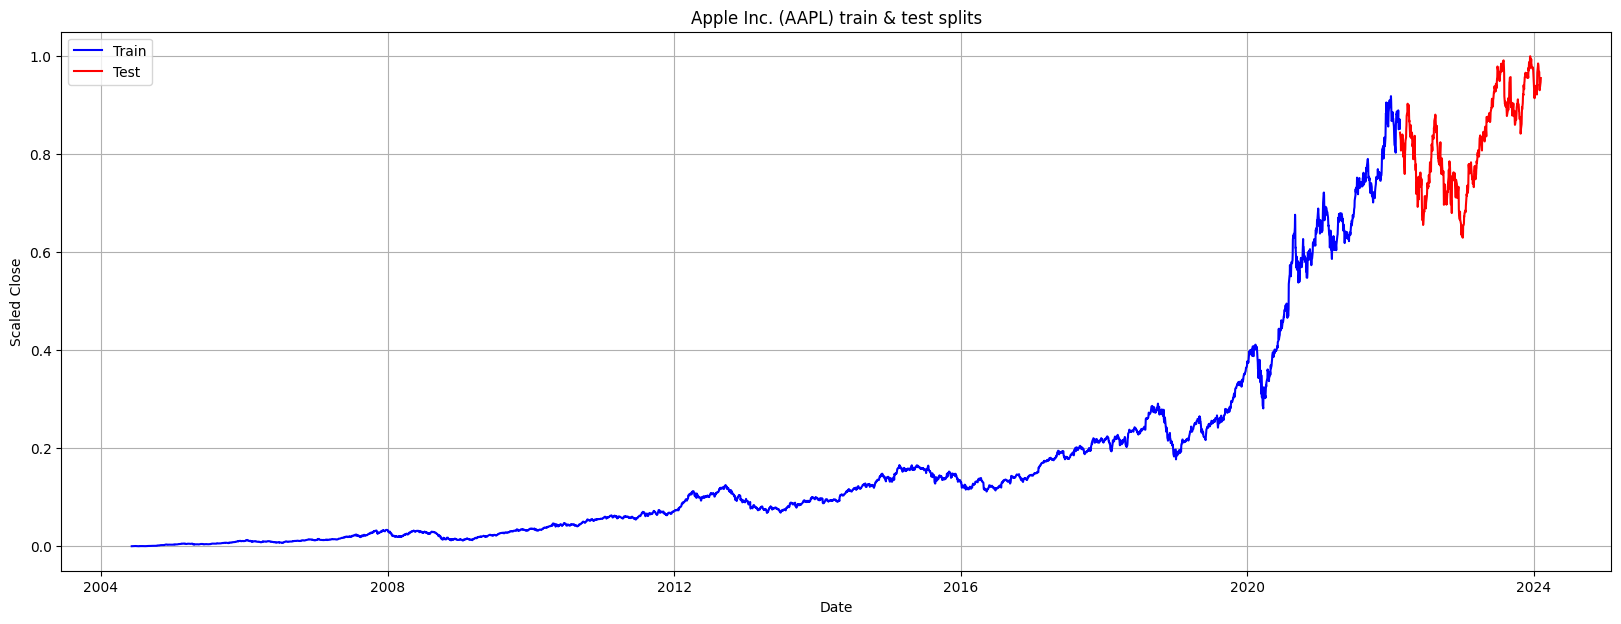

In [154]:
# Plot train and test data
plt.figure(figsize=(20, 7))
plt.plot(train_data['datetime'], train_data['close'], label='Train', color='blue')
# plt.plot(valid_data['datetime'], valid_data['scaled_close'], label='Valid', color='orange')
plt.plot(test_data['datetime'], test_data['close'], label='Test', color='red')

plt.title('Apple Inc. (AAPL) train & test splits')
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.legend()
plt.grid(True)

plt.show()

In [155]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_valid = X_valid.values.reshape(X_valid.shape[0], 1, X_valid.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [156]:
# Define the LSTM model
model = Sequential([
    LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                880       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 891 (3.48 KB)
Trainable params: 891 (3.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [157]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
203/203 [==============================] - 3s 5ms/step - loss: 0.0060
Epoch 2/20
203/203 [==============================] - 1s 5ms/step - loss: 2.0487e-04
Epoch 3/20
203/203 [==============================] - 1s 5ms/step - loss: 7.2216e-05
Epoch 4/20
203/203 [==============================] - 1s 4ms/step - loss: 4.9642e-05
Epoch 5/20
203/203 [==============================] - 1s 4ms/step - loss: 4.1497e-05
Epoch 6/20
203/203 [==============================] - 1s 3ms/step - loss: 3.8881e-05
Epoch 7/20
203/203 [==============================] - 1s 3ms/step - loss: 3.7349e-05
Epoch 8/20
203/203 [==============================] - 1s 3ms/step - loss: 3.7032e-05
Epoch 9/20
203/203 [==============================] - 1s 3ms/step - loss: 3.6801e-05
Epoch 10/20
203/203 [==============================] - 1s 3ms/step - loss: 3.5660e-05
Epoch 11/20
203/203 [==============================] - 1s 3ms/step - loss: 3.6114e-05
Epoch 12/20
203/203 [==============================] - 1s 3ms/step 

In [159]:
# 6. Evaluate the Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

23/23 [==============================] - 0s 2ms/step
Mean Squared Error: 0.00028276136948109435
Root Mean Squared Error: 0.016815509789509634


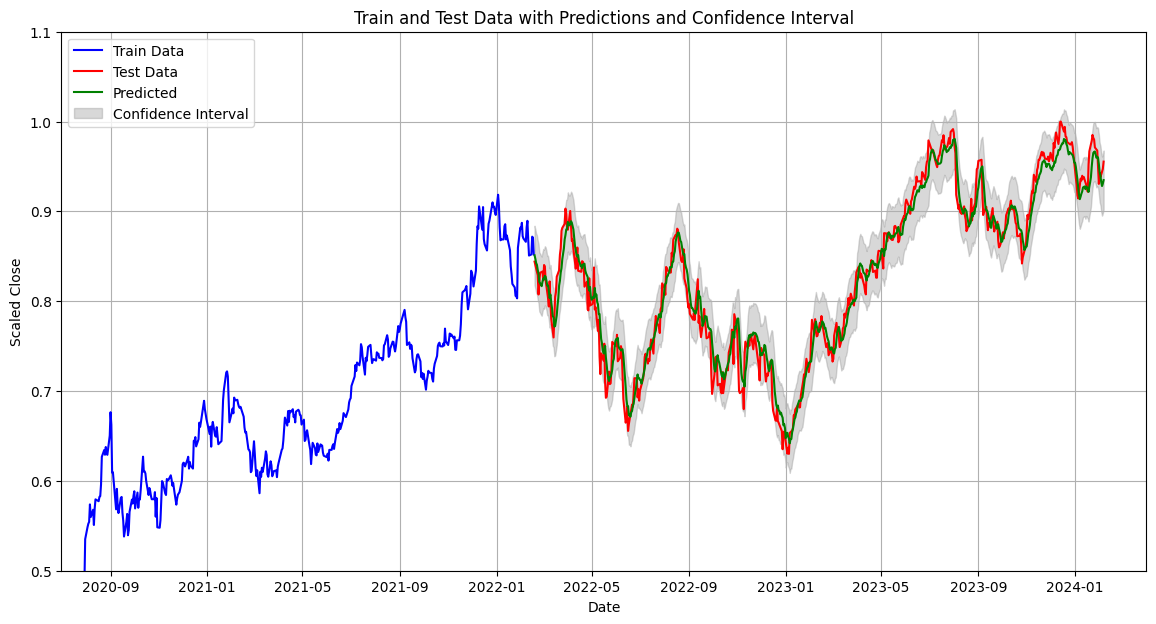

In [160]:
# Calculate residuals
residuals = y_test - y_pred.reshape(-1)

# Compute standard deviation of residuals
std_dev = np.std(residuals)

# Calculate confidence intervals
confidence_interval = 1.96 * std_dev  # 95% confidence interval

# Plotting
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_data['datetime'], train_data['close'], label='Train Data', color='blue')

# Plot test data
plt.plot(test_data['datetime'], test_data['close'], label='Test Data', color='red')

# Plot predicted values
plt.plot(test_data['datetime'], y_pred, label='Predicted', color='green')

# Compute upper and lower bounds for confidence interval
upper_bound = y_pred + confidence_interval
lower_bound = y_pred - confidence_interval

# # Plot confidence interval
plt.fill_between(test_data['datetime'], upper_bound.flatten(), lower_bound.flatten(), color='gray', alpha=0.3, label='Confidence Interval')

# Set x-axis limits
plt.xlim(pd.Timestamp('2020-07-01'), pd.Timestamp('2024-03-31'))
# Set y-axis limits
plt.ylim(0.5, 1.1)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.title('Train and Test Data with Predictions and Confidence Interval')
plt.legend()
plt.grid(True)

# Show plot
plt.show()